## Google Colab setup

In [1]:
# If you're running on colab, indicate as such:
is_colab = True

if is_colab:
    from google.colab import drive
    import os
    import shutil

    # Mount drive to colab
    drive.mount('/content/drive', force_remount=True)

    # setting up paths
    # Edit this path to where you've uploaded the repo files.
    path_to_project_files = '/content/drive/MyDrive/GaTech/2025 1Spring/DL/DeepLearning'
    existing = os.path.join(path_to_project_files, 'kaggle.json')
    path_to_colab_utils = '/root/.kaggle'
    target = os.path.join(path_to_colab_utils, 'kaggle.json')

    # move the key to the colab root
    os.makedirs(path_to_colab_utils, exist_ok=True)
    shutil.copy(existing, target)
    os.chmod(target, 600)

    # download the data into /content (which is temporary)
    !kaggle datasets download -d xhlulu/leafsnap-dataset -p /content --unzip

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/xhlulu/leafsnap-dataset
License(s): copyright-authors


In [2]:
if is_colab:
    import sys
    # This ensures that imports are recognized correctly.
    sys.path.append(path_to_project_files)

## Library Imports

In [3]:
from autoencoder import *
from dataloader import *

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import os
from sklearn.metrics import f1_score

In [4]:
import matplotlib.pyplot as plt

def showTensorInNotebook(tensor):
    """
    This takes a (3[RGB], H, W) tensor in R[0.0, 1.0] and displays it with matplotlib.
    """
    image = tensor.detach().cpu().numpy().transpose(1,2,0) # move the channel axis to the end, because PIL and matplotlib hate each other
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Building the data loader

These are transforms that allow us to ingest the image tensors with some extra confusion at training time. `processor` makes the data loader spit out tensors, and `noiser` adds Gaussian noise.

NOTE: If you do not resize the images, the DataLoader will get upset, since the LeafSnap dataset does not have uniform size.

In [28]:
# This just processes the images.
H, W = 400, 400

processor = v2.Compose([
    v2.Resize((H, W)),
    lambda x: x / 255.0, # convert Z[0, 255] to R[0.0, 1.0]
])
BATCH_SIZE = 128

# This adds the noise for training.
NOISE_RATIO = 0.1
noiser = v2.Compose([
    lambda x: torch.clip(x + NOISE_RATIO*torch.randn_like(x), 0.0, 1.0) # add the noise
])

Now we need to build the torch.utils.data.DataLoaders for train and test.

When iterating, you'll get a Tensor of `(BATCH_SIZE, 4 if use_segmented else 3, H, W)`.

In [29]:
root_directory = os.path.join(os.getcwd(), 'leafsnap-dataset')

LS_base_dataset = LeafsnapDataset(os.path.join(path_to_project_files, 'train.txt'), root_directory, use_segmented=False, source="both", transform=processor)
LS_2_dataset = LeafsnapDataset(os.path.join(path_to_project_files, 'misctrain2.txt'), root_directory, use_segmented=False, source="both", transform=processor)
LS_3_dataset = LeafsnapDataset(os.path.join(path_to_project_files, 'misctrain3.txt'), root_directory, use_segmented=False, source="both", transform=processor)
LS_4_dataset = LeafsnapDataset(os.path.join(path_to_project_files, 'misctrain4.txt'), root_directory, use_segmented=False, source="both", transform=processor)
flavia_dataset = FlaviaDataset(os.path.join(path_to_project_files, 'Leaves'), transform=processor)

AE_train_dataset = CombinedDataset([LS_base_dataset, LS_2_dataset, LS_3_dataset, LS_4_dataset, flavia_dataset])
AE_train_dataloader = DataLoader(AE_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
clf_train_dataloader = DataLoader(LS_base_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [30]:
test_dataset = LeafsnapDataset(os.path.join(path_to_project_files, 'test.txt'), root_directory, use_segmented=False, source="both", transform=processor)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Training the Denoising CAE

This is a convolutional autoencoder. With convolution and pooling, the 3x400x400 images are shrunk to a 16x25x25 tensor, which is passed through a linear layer bottleneck. The idea is to feed it a noised image, and train the model to denoise the image. Then, hopefully, the bottleneck learns rich information about the image, which can be used as an embedding.

In [ ]:
model = FinalConvolutionalAutoencoder((BATCH_SIZE, 3, 400, 400), noiser, device=device)

In [ ]:
# If you already have a trained model, you can just load the weights.
is_model_trained = True
if not is_model_trained:
    train_AE_model(model, AE_train_dataloader, 10, 5e-5, device=device)
else:
    model.load_state_dict(torch.load('C+_DAE.pth'))

Now, a test run of the reconstruction.

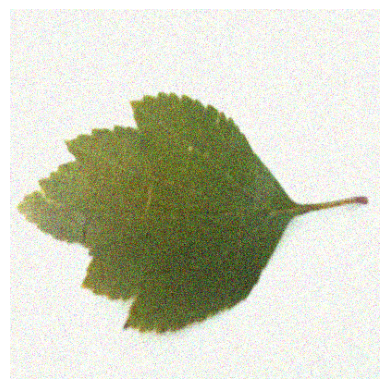

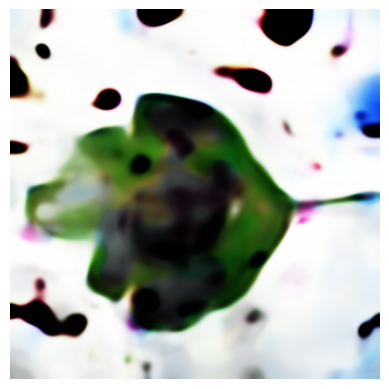

In [ ]:
sample_train_image = noiser(AE_train_dataset.__getitem__(200)[0].unsqueeze(0)).to(device)
showTensorInNotebook(sample_train_image.squeeze(0))
reconstruction = model.forward(sample_train_image)
showTensorInNotebook(reconstruction.squeeze(0))

In [ ]:
torch.save(model.state_dict(), 'C+_DAE.pth')

## Training the DN-CAE classifier head

In [ ]:
trained_autoencoder = FinalConvolutionalAutoencoder((BATCH_SIZE, 3, 400, 400), noiser, device=device)
trained_autoencoder.load_state_dict(torch.load('C+_DAE.pth'))
trained_autoencoder.eval()

classifier = AEClassifier(trained_autoencoder.encoder, [500, 500, 500, 185], device=device)
for param in classifier.encoder.parameters():
    param.requires_grad = False

In [ ]:
# If you already have a trained model, you can just load the weights.
is_model_trained = False
if not is_model_trained:
    train_classifier_head(classifier, clf_train_dataloader, 50, 5e-5, device=device)
else:
    classifier.load_state_dict(torch.load('DN-CAE_classifier.pth'))

Epoch 1/50: 100%|██████████| 110/110 [01:15<00:00,  1.45it/s, batch=110/110, loss=4.98]


Epoch 1 average loss: 5.0503


Epoch 2/50: 100%|██████████| 110/110 [01:15<00:00,  1.46it/s, batch=110/110, loss=5.03]


Epoch 2 average loss: 5.0503


Epoch 3/50: 100%|██████████| 110/110 [01:15<00:00,  1.45it/s, batch=110/110, loss=5.13]


Epoch 3 average loss: 5.0508


Epoch 4/50: 100%|██████████| 110/110 [01:15<00:00,  1.45it/s, batch=110/110, loss=4.98]


Epoch 4 average loss: 5.0498


Epoch 5/50: 100%|██████████| 110/110 [01:15<00:00,  1.45it/s, batch=110/110, loss=5.08]


Epoch 5 average loss: 5.0500


Epoch 6/50: 100%|██████████| 110/110 [01:15<00:00,  1.46it/s, batch=110/110, loss=5.13]


Epoch 6 average loss: 5.0501


Epoch 7/50: 100%|██████████| 110/110 [01:15<00:00,  1.46it/s, batch=110/110, loss=4.98]


Epoch 7 average loss: 5.0490


Epoch 8/50: 100%|██████████| 110/110 [01:15<00:00,  1.46it/s, batch=110/110, loss=4.93]


Epoch 8 average loss: 5.0483


Epoch 9/50: 100%|██████████| 110/110 [01:15<00:00,  1.46it/s, batch=110/110, loss=5.18]


Epoch 9 average loss: 5.0500


Epoch 10/50: 100%|██████████| 110/110 [01:15<00:00,  1.46it/s, batch=110/110, loss=4.98]


Epoch 10 average loss: 5.0483


Epoch 11/50: 100%|██████████| 110/110 [01:15<00:00,  1.45it/s, batch=110/110, loss=5.03]


Epoch 11 average loss: 5.0480


Epoch 12/50: 100%|██████████| 110/110 [01:15<00:00,  1.46it/s, batch=110/110, loss=5.08]


Epoch 12 average loss: 5.0478


Epoch 13/50: 100%|██████████| 110/110 [01:15<00:00,  1.46it/s, batch=110/110, loss=4.93]


Epoch 13 average loss: 5.0470


Epoch 14/50: 100%|██████████| 110/110 [01:15<00:00,  1.47it/s, batch=110/110, loss=4.93]


Epoch 14 average loss: 5.0466


Epoch 15/50: 100%|██████████| 110/110 [01:17<00:00,  1.42it/s, batch=110/110, loss=5.13]


Epoch 15 average loss: 5.0477


Epoch 16/50: 100%|██████████| 110/110 [01:17<00:00,  1.43it/s, batch=110/110, loss=4.93]


Epoch 16 average loss: 5.0462


Epoch 17/50: 100%|██████████| 110/110 [01:16<00:00,  1.44it/s, batch=110/110, loss=4.93]


Epoch 17 average loss: 5.0459


Epoch 18/50: 100%|██████████| 110/110 [01:16<00:00,  1.45it/s, batch=110/110, loss=5.13]


Epoch 18 average loss: 5.0472


Epoch 19/50: 100%|██████████| 110/110 [01:16<00:00,  1.45it/s, batch=110/110, loss=5.08]


Epoch 19 average loss: 5.0468


Epoch 20/50: 100%|██████████| 110/110 [01:16<00:00,  1.43it/s, batch=110/110, loss=5.13]


Epoch 20 average loss: 5.0473


Epoch 21/50: 100%|██████████| 110/110 [01:16<00:00,  1.43it/s, batch=110/110, loss=5.08]


Epoch 21 average loss: 5.0464


Epoch 22/50: 100%|██████████| 110/110 [01:16<00:00,  1.43it/s, batch=110/110, loss=5]


Epoch 22 average loss: 5.0453


Epoch 23/50: 100%|██████████| 110/110 [01:16<00:00,  1.44it/s, batch=110/110, loss=4.98]


Epoch 23 average loss: 5.0446


Epoch 24/50: 100%|██████████| 110/110 [01:15<00:00,  1.45it/s, batch=110/110, loss=4.98]


Epoch 24 average loss: 5.0448


Epoch 25/50: 100%|██████████| 110/110 [01:15<00:00,  1.45it/s, batch=110/110, loss=5.08]


Epoch 25 average loss: 5.0452


Epoch 26/50: 100%|██████████| 110/110 [01:15<00:00,  1.46it/s, batch=110/110, loss=4.9]


Epoch 26 average loss: 5.0426


Epoch 27/50: 100%|██████████| 110/110 [01:15<00:00,  1.46it/s, batch=110/110, loss=4.93]


Epoch 27 average loss: 5.0431


Epoch 28/50: 100%|██████████| 110/110 [01:15<00:00,  1.46it/s, batch=110/110, loss=5.08]


Epoch 28 average loss: 5.0438


Epoch 29/50: 100%|██████████| 110/110 [01:14<00:00,  1.47it/s, batch=110/110, loss=5.08]


Epoch 29 average loss: 5.0433


Epoch 30/50: 100%|██████████| 110/110 [01:15<00:00,  1.46it/s, batch=110/110, loss=5.13]


Epoch 30 average loss: 5.0437


Epoch 31/50: 100%|██████████| 110/110 [01:15<00:00,  1.46it/s, batch=110/110, loss=4.93]


Epoch 31 average loss: 5.0419


Epoch 32/50: 100%|██████████| 110/110 [01:15<00:00,  1.47it/s, batch=110/110, loss=4.98]


Epoch 32 average loss: 5.0420


Epoch 33/50: 100%|██████████| 110/110 [01:15<00:00,  1.46it/s, batch=110/110, loss=4.88]


Epoch 33 average loss: 5.0400


Epoch 34/50: 100%|██████████| 110/110 [01:15<00:00,  1.46it/s, batch=110/110, loss=5.03]


Epoch 34 average loss: 5.0405


Epoch 35/50: 100%|██████████| 110/110 [01:14<00:00,  1.47it/s, batch=110/110, loss=5.08]


Epoch 35 average loss: 5.0404


Epoch 36/50: 100%|██████████| 110/110 [01:14<00:00,  1.47it/s, batch=110/110, loss=5.03]


Epoch 36 average loss: 5.0395


Epoch 37/50: 100%|██████████| 110/110 [01:14<00:00,  1.47it/s, batch=110/110, loss=5.13]


Epoch 37 average loss: 5.0395


Epoch 38/50: 100%|██████████| 110/110 [01:14<00:00,  1.47it/s, batch=110/110, loss=5.18]


Epoch 38 average loss: 5.0395


Epoch 39/50: 100%|██████████| 110/110 [01:14<00:00,  1.47it/s, batch=110/110, loss=5.03]


Epoch 39 average loss: 5.0384


Epoch 40/50: 100%|██████████| 110/110 [01:14<00:00,  1.47it/s, batch=110/110, loss=5.05]


Epoch 40 average loss: 5.0385


Epoch 41/50: 100%|██████████| 110/110 [01:14<00:00,  1.47it/s, batch=110/110, loss=4.84]


Epoch 41 average loss: 5.0367


Epoch 42/50: 100%|██████████| 110/110 [01:14<00:00,  1.47it/s, batch=110/110, loss=4.98]


Epoch 42 average loss: 5.0376


Epoch 43/50: 100%|██████████| 110/110 [01:14<00:00,  1.47it/s, batch=110/110, loss=5.03]


Epoch 43 average loss: 5.0376


Epoch 44/50: 100%|██████████| 110/110 [01:14<00:00,  1.47it/s, batch=110/110, loss=5.08]


Epoch 44 average loss: 5.0378


Epoch 45/50: 100%|██████████| 110/110 [01:14<00:00,  1.47it/s, batch=110/110, loss=5.03]


Epoch 45 average loss: 5.0374


Epoch 46/50: 100%|██████████| 110/110 [01:14<00:00,  1.47it/s, batch=110/110, loss=5.03]


Epoch 46 average loss: 5.0371


Epoch 47/50: 100%|██████████| 110/110 [01:16<00:00,  1.44it/s, batch=110/110, loss=5.03]


Epoch 47 average loss: 5.0370


Epoch 48/50: 100%|██████████| 110/110 [01:18<00:00,  1.41it/s, batch=110/110, loss=4.93]


Epoch 48 average loss: 5.0361


Epoch 49/50: 100%|██████████| 110/110 [01:17<00:00,  1.42it/s, batch=110/110, loss=4.98]


Epoch 49 average loss: 5.0366


Epoch 50/50: 100%|██████████| 110/110 [01:17<00:00,  1.42it/s, batch=110/110, loss=5.03]

Epoch 50 average loss: 5.0370


In [ ]:
correct_top1 = 0
correct_top5 = 0
total = 0
all_preds = []
all_labels = []

classifier.to(device)
with torch.no_grad(): # No gradients needed for evaluation
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = classifier(inputs)

        # Top-1 Accuracy
        _, predicted = torch.max(outputs, 1)
        correct_top1 += (predicted == labels).sum().item()

        # Top-5 Accuracy
        top5_preds = torch.topk(outputs, 5, dim=1).indices
        correct_top5 += torch.sum(top5_preds.eq(labels.view(-1, 1))).item()

        total += labels.size(0)

        # For Macro-F1
        all_preds.append(predicted.cpu())
        all_labels.append(labels.cpu())
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute metrics
top1_accuracy = 100 * correct_top1 / total
top5_accuracy = 100 * correct_top5 / total
macro_f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")
print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")
print(f"Macro F1 Score: {macro_f1:.4f}")


Top-1 Accuracy: 16.48%
Top-5 Accuracy: 18.72%
Macro F1 Score: 0.0680


In [ ]:
torch.save(classifier.state_dict(), "C+_DAE_classifier.pth")

## Training the C-VAE

This is a convolutional variational autoencoder. With strided convolution, the 3x400x400 images are shrunk to a 256x25x25 tensor, which is passed through a VAE reparametrization bottleneck layer. Unlike previous approaches, this is not a denoiser, since VAE's aren't well conditioned for denoising. This is simply going to learn reconstruction through variational features.

In [31]:
# This means we need a new transform for learning, since it's not denoising.
perturber = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip()
])

In [78]:
model = VariationalAutoencoder((BATCH_SIZE, 3, 400, 400), perturber, device=device, latent_dim=500)

In [79]:
# If you already have a trained model, you can just load the weights.
is_model_trained = True
if not is_model_trained:
    train_VAE_model(model, AE_train_dataloader, 4, 2e-4, device=device, beta=1.2)
else:
    model.load_state_dict(torch.load('C_VAE.pth'))

In [74]:
torch.save(model.state_dict(), 'C_VAE.pth')

Now, a test run of the reconstruction.

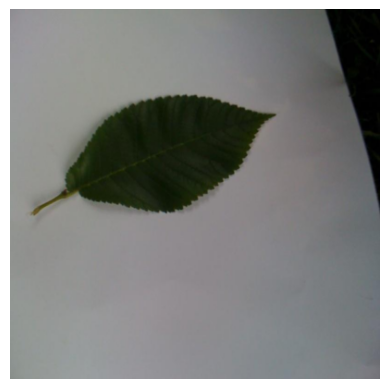

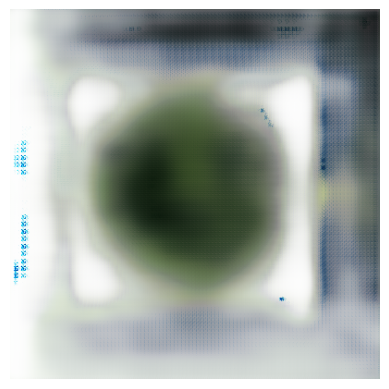

In [80]:
sample_train_image = perturber(AE_train_dataset.__getitem__(12300)[0]).unsqueeze(0).to(device)
showTensorInNotebook(sample_train_image.squeeze(0))
reconstruction, mu, logvar = model.forward(sample_train_image)
showTensorInNotebook(reconstruction.squeeze(0))

Additionally, nominally, VAEs can be used to easily generate. Let's see that!

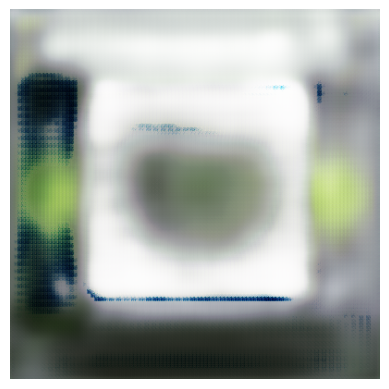

In [77]:
noise = torch.randn((1, 500,)).to(device)
reconstruction = model.decoder(noise)
showTensorInNotebook(reconstruction.squeeze(0))

## Training the C-VAE Classification Head

In [81]:
trained_VAE = VariationalAutoencoder((BATCH_SIZE, 3, 400, 400), perturber, device=device, latent_dim=500)
trained_VAE.load_state_dict(torch.load('C_VAE.pth'))
trained_VAE.eval()

class VAEEmbedder(torch.nn.Module):
    def __init__(self, encoder, mu):
        super().__init__()
        self.encoder = encoder
        self.mu = mu

    def forward(self, x):
        x = self.encoder(x)
        x = self.mu(x)
        return x

embedder = VAEEmbedder(trained_VAE.encoder, trained_VAE.mu)

classifier = AEClassifier(embedder, [500, 500, 500, 185], device=device)
for param in classifier.encoder.parameters():
    param.requires_grad = False

In [ ]:
# If you already have a trained model, you can just load the weights.
is_model_trained = False
if not is_model_trained:
    train_classifier_head(classifier, clf_train_dataloader, 50, 1e-4, device=device)
else:
    classifier.load_state_dict(torch.load('C_VAE-classifier.pth'))

In [63]:
correct_top1 = 0
correct_top5 = 0
total = 0
all_preds = []
all_labels = []

classifier.to(device)
with torch.no_grad(): # No gradients needed for evaluation
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = classifier(inputs)

        # Top-1 Accuracy
        _, predicted = torch.max(outputs, 1)
        correct_top1 += (predicted == labels).sum().item()

        # Top-5 Accuracy
        top5_preds = torch.topk(outputs, 5, dim=1).indices
        correct_top5 += torch.sum(top5_preds.eq(labels.view(-1, 1))).item()

        total += labels.size(0)

        # For Macro-F1
        all_preds.append(predicted.cpu())
        all_labels.append(labels.cpu())
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute metrics
top1_accuracy = 100 * correct_top1 / total
top5_accuracy = 100 * correct_top5 / total
macro_f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")
print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")
print(f"Macro F1 Score: {macro_f1:.4f}")


Top-1 Accuracy: 8.90%
Top-5 Accuracy: 13.99%
Macro F1 Score: 0.0171


In [ ]:
torch.save(classifier.state_dict(), 'C_VAE-classifier.pth')